In [8]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

Note that, as we do not have a distinct churn value for our customers, the retention rate is at such a low value and we are missing datapoints, there is no real way to predict customer churning for this set of data. However in the following I will show a small bit of code to build a simple model to predict churn.

In [3]:
df = pd.read_pickle("./Data/clv2u.pickle")

In [4]:
#lets say that if the prediction for a future buy is bigger than 1 the customer has churn of no(0), else yes(1)
def churnfunc(value):
    return 0 if value >= 1 else 1
df["churn"] = df.predicted_purchases_oneyear.apply(churnfunc)

In [43]:
X = df.drop(['churn','user_id', 'country', 'region', 'city',"predicted_purchases_oneyear", "frequency"],axis=1)
y = df.churn

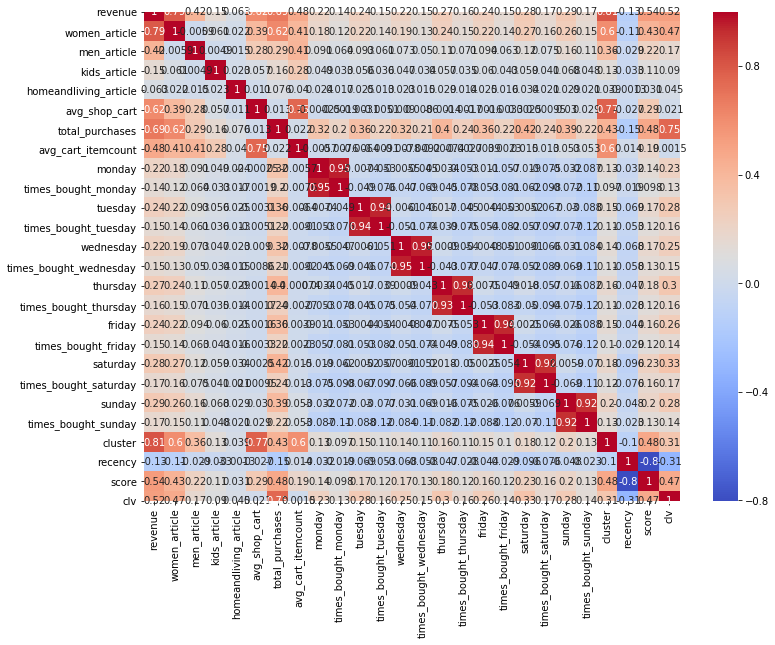

In [44]:
plt.figure(figsize = (12,9))
sns.heatmap(X.corr(), annot=True, cmap = 'coolwarm')

In [45]:
X = pd.get_dummies(X)

In [30]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective='binary:logistic', n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [31]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1570
           1       1.00      1.00      1.00     60692

    accuracy                           1.00     62262
   macro avg       0.98      0.99      0.98     62262
weighted avg       1.00      1.00      1.00     62262



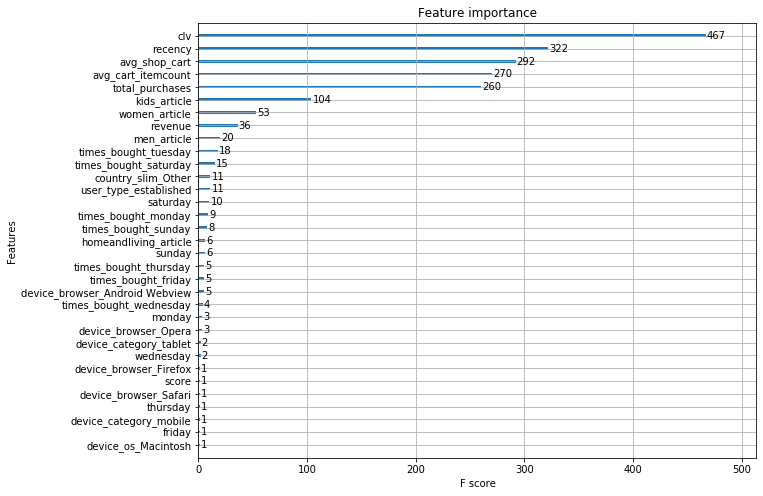

In [33]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [46]:
X['churn_prob'] = xgb_model.predict_proba(X)[:,1]

In [49]:
plc = X["churn_prob"]

In [52]:
df_churn = df.join(plc)

In [54]:
df_churn.to_pickle("Data/churn.pickle")